In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sys, os, time
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tensorflow_addons.optimizers import CyclicalLearningRate
import pickle

from utils import get_tf_datasets, fetch_callbacks, get_tf_dataset_sampled, heteroscedastic_loss_wrapper
from model import get_model

# from competition baseline
from base_code.helper import to_observed_matrix

In [3]:
np.random.seed(42)
tf.keras.utils.set_random_seed(42)

# Load data and declare variables
- e.g. file paths, targets, etc.

In [ ]:
# adjust as needed
training_path = 'data/FullDataset/TrainingData'

In [4]:
training_GT_path = os.path.join(training_path, 'Ground Truth Package')
GT_trace_path = os.path.join(training_GT_path, 'Tracedata.hdf5')

spectral_training_data = h5py.File(os.path.join(training_path,'SpectralData.hdf5'),"r")
aux_data = pd.read_csv(os.path.join(training_path,'AuxillaryTable.csv'))
soft_label_data = pd.read_csv(os.path.join(training_GT_path, 'FM_Parameter_Table.csv'))

trace_file = h5py.File(GT_trace_path)

if 'Unnamed: 0' in soft_label_data.columns:
    soft_label_data = soft_label_data.drop(['Unnamed: 0'], axis=1)

# assume this order?
target_labels = ['planet_radius','planet_temp','log_H2O','log_CO2','log_CO','log_CH4','log_NH3']
num_targets = len(target_labels)

target_scales_dict = {
    'planet_radius': [0.1, 3],
    'planet_temp': [0, 7000],
    'log_H2O': [-12, -1],
    'log_CO2': [-12, -1],
    'log_CO': [-12, -1],
    'log_CH4': [-12, -1],
    'log_NH3': [-12, -1]
}

target_scales_arr = np.array([target_scales_dict[l] for l in target_labels]) # safer, in case dict unordered
min_vals = target_scales_arr[:, 0]
max_vals = target_scales_arr[:, 1]

In [5]:
spec_matrix_file = 'spec_matrix.npy'
if spec_matrix_file in os.listdir('data/'):
    print('opening existing spec matrix file')
    with open('data/spec_matrix.npy', 'rb') as f:
        spec_matrix = np.load(f)
    print('spectra shape:', spec_matrix.shape)
else:
    print('constructing spec matrix and saving to file')
    start_time = time.time()
    spec_matrix = to_observed_matrix(spectral_training_data, aux_data)
    with open('data/spec_matrix.npy', 'wb') as f:
        np.save(f, spec_matrix)
    print("finished after: {}, spectral matrix shape: {}".format(time.time() - start_time, spec_matrix.shape))

noise = spec_matrix[:, :, 2]
spectra = spec_matrix[:, :, 1]
wl_grid = spec_matrix[:, :, 0]
bin_width = spec_matrix[:, :, 3]

global_spectra_mean = np.mean(spectra)
global_spectra_std = np.std(spectra)
print(f'spectra mean: {global_spectra_mean}, std: {global_spectra_std}')

wl_channels = spectra.shape[1] # wavelength_channels

opening existing spec matrix file
spectra shape: (41423, 52, 4)
spectra mean: 0.008257788618509107, std: 0.011651996038057373


# Feature Engineering
- spectra stats
- ratio of planet mass to star mass
- star density
- planet_semimajor_axis: 
    - https://en.wikipedia.org/wiki/Orbital_period#Two_bodies_orbiting_each_other
- planet equilibrium temperature (planet_eqlbm_temp)
    - see equation (7): https://www.astro.princeton.edu/~strauss/FRS113/writeup3/

In [6]:
spectra_rw_mean = spectra.mean(axis=1)
spectra_rw_std = spectra.std(axis=1)
spectra_rw_min = spectra.min(axis=1)
spectra_rw_max = spectra.max(axis=1)

aux_data['spectra_rw_mean'] = spectra_rw_mean
aux_data['spectra_rw_std'] = spectra_rw_std
aux_data['spectra_rw_min'] = spectra_rw_min
aux_data['spectra_rw_max'] = spectra_rw_max

In [7]:
aux_data['planet_mass_kg/star_mass_kg'] = aux_data['planet_mass_kg']/aux_data['star_mass_kg']
aux_data['star_density'] = aux_data['star_mass_kg']*(4/3)*np.pi*(aux_data['star_radius_m']**3)

# technically this needs Albedo's constant. i.e. (1 - A)^(1/4)
aux_data['planet_eqlbm_temp'] = np.sqrt(aux_data['star_radius_m']/(2*aux_data['planet_distance']))*aux_data['star_temperature']

# Kepler's third law (technically this needs the graviational constant)
aux_data['planet_semimajor_axis'] = ((aux_data['star_mass_kg'] + aux_data['planet_mass_kg'])*((aux_data['planet_orbital_period']/(2*np.pi))**2))**(1/3)

### Plot of dstributions shows skew

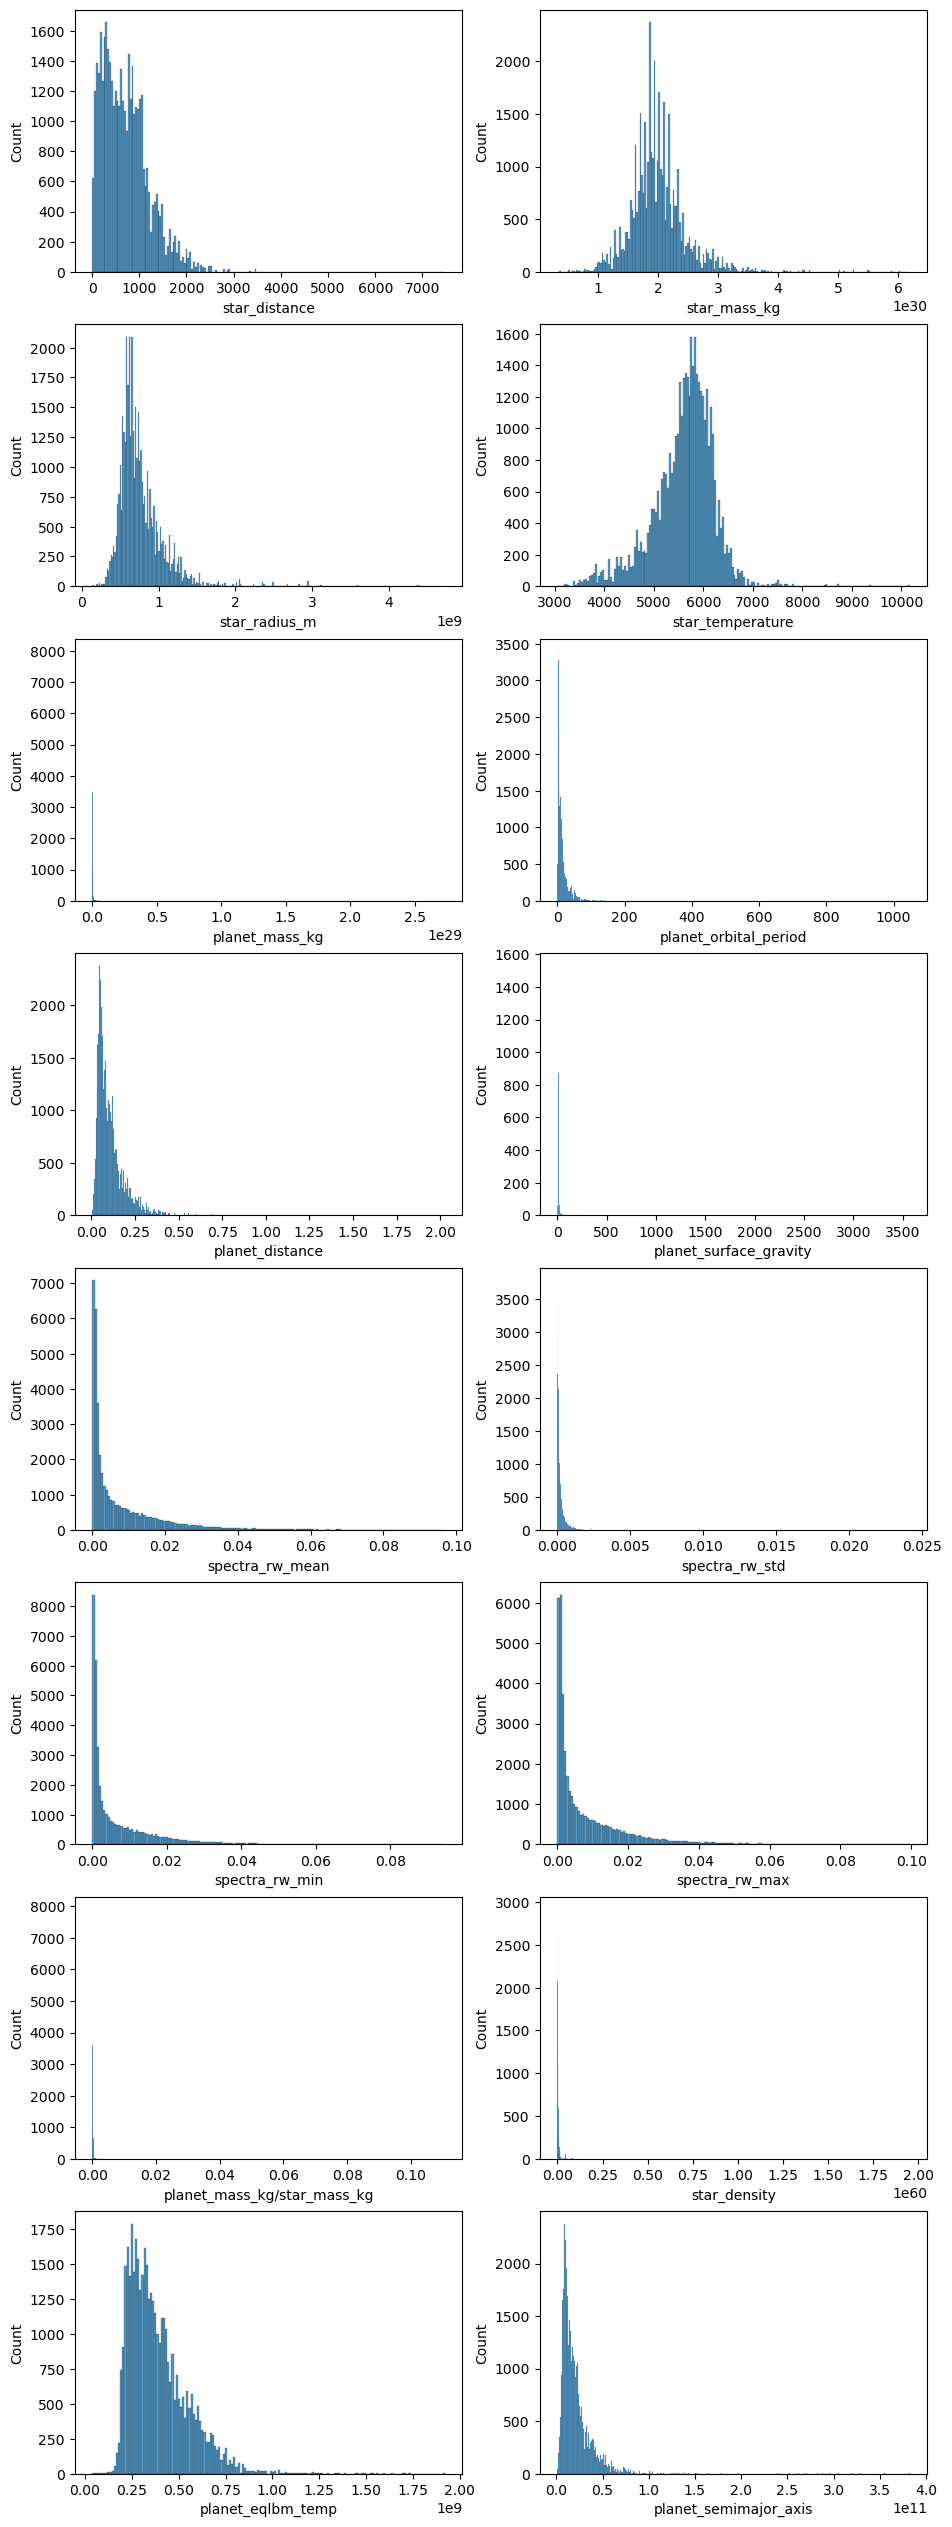

In [8]:
cols = [c for c in aux_data.columns if c != 'planet_ID']

num_cols = 2
num_rows = int(np.ceil(len(cols)/num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(11, 4*num_rows))

for n in range(num_rows):
    for m in range(num_cols):
        col_idx = n*num_cols + m
        sns.histplot(aux_data[cols[col_idx]], kde=False, ax=axs[n, m], label=cols[col_idx])

<AxesSubplot:xlabel='spectra_rw_mean', ylabel='Count'>

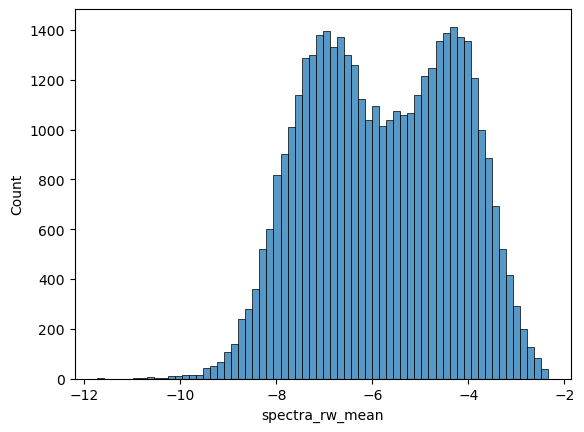

In [9]:
sns.histplot(np.log(aux_data['spectra_rw_mean']))

### Apply log transfrom

In [10]:
cols = [c for c in aux_data.columns if c != 'planet_ID']
for c in cols:
    aux_data[c] = np.log(aux_data[c])

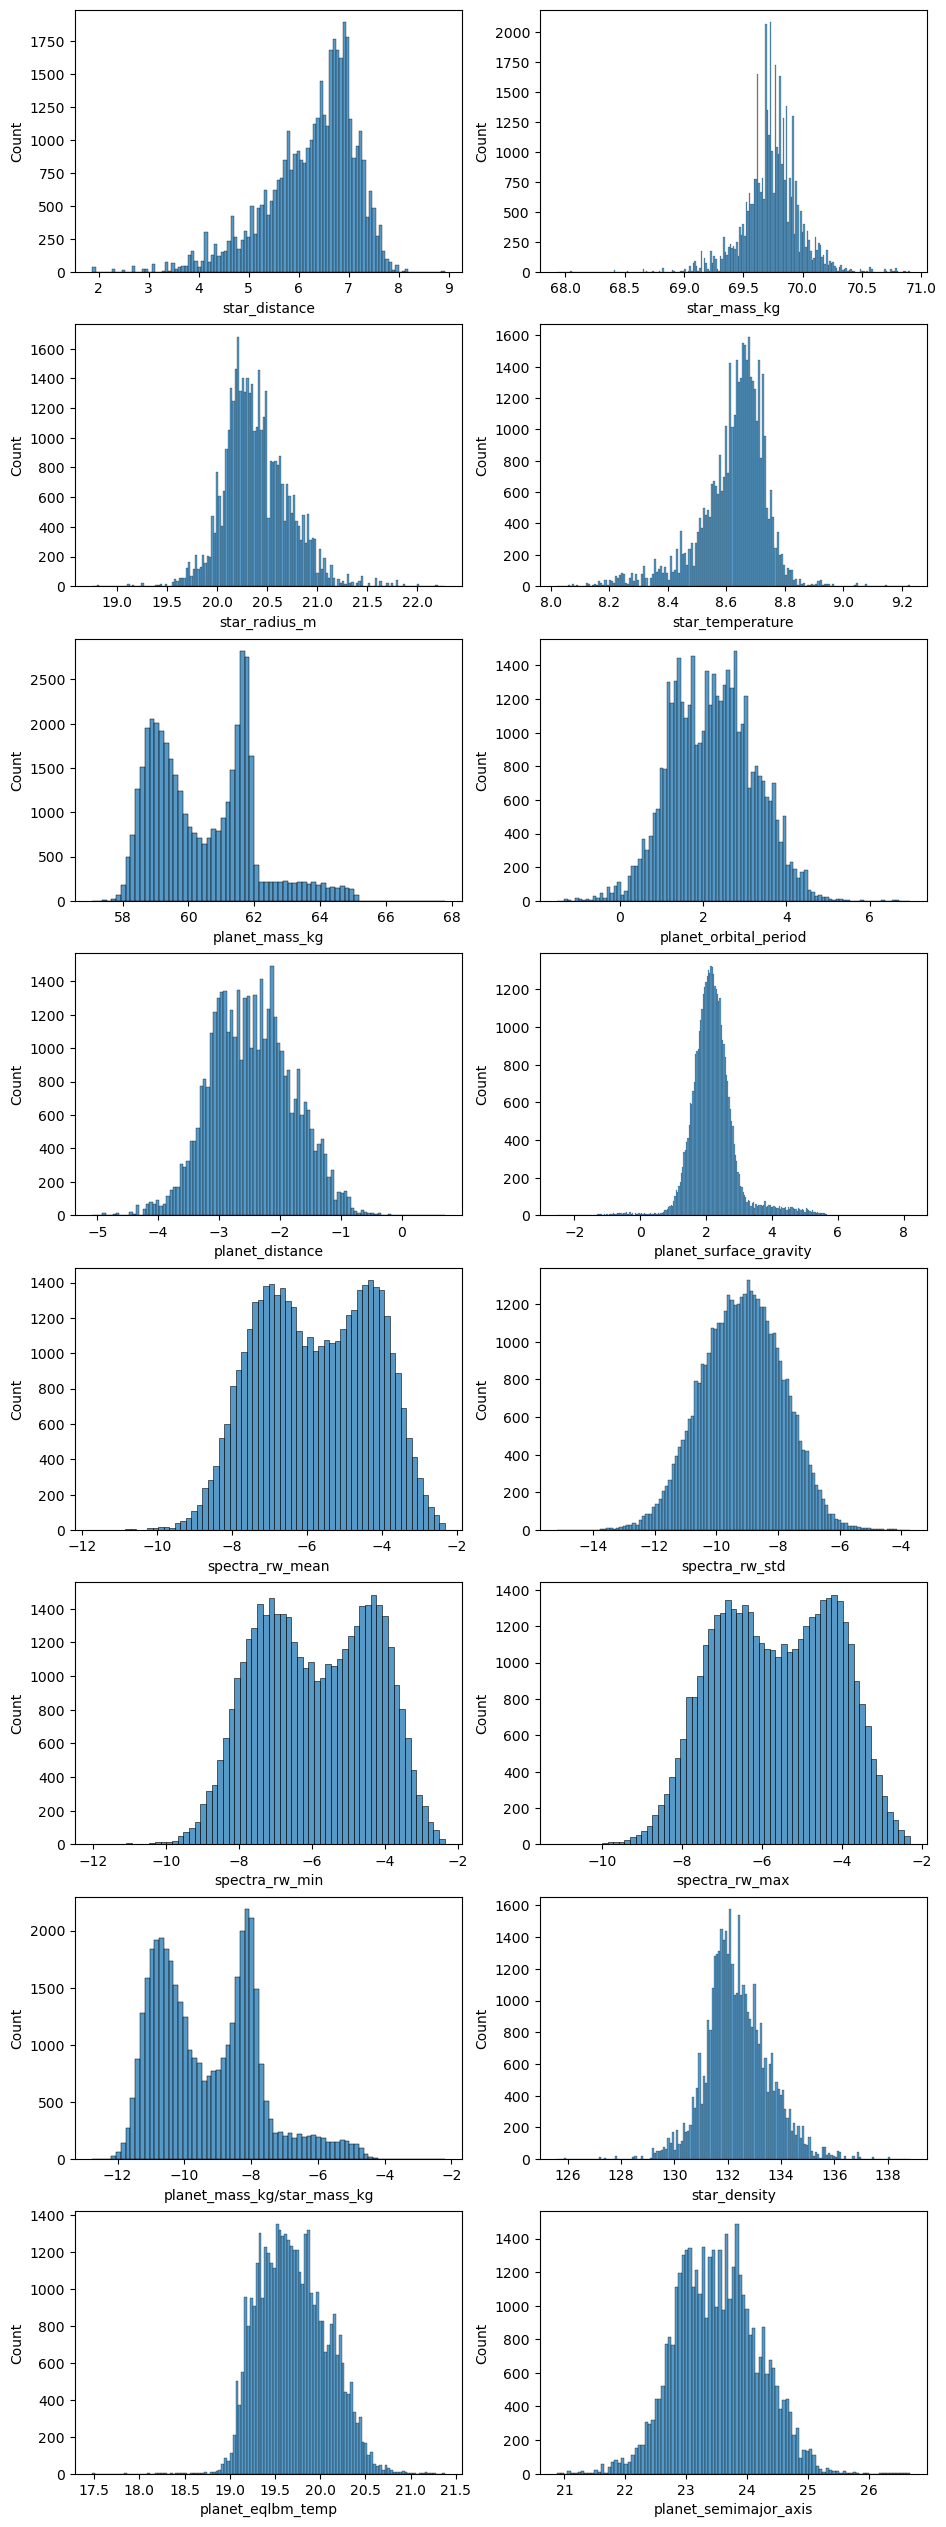

In [11]:
cols = [c for c in aux_data.columns if c != 'planet_ID']

num_cols = 2
num_rows = int(np.ceil(len(cols)/num_cols))

fig, axs = plt.subplots(num_rows, num_cols, figsize=(11, 4*num_rows))

for n in range(num_rows):
    for m in range(num_cols):
        col_idx = n*num_cols + m
        sns.histplot(aux_data[cols[col_idx]], kde=False, ax=axs[n, m], label=cols[col_idx])

# Get which planets have trace data

In [12]:
planet_desc_filename = 'planets_data_desc.csv'

if planet_desc_filename in os.listdir():
    print('reading from file')
    df_planet_has_data = pd.read_csv('planets_data_desc.csv')

else:
    print('building planet_data_desc')
    planet_list = [p for p in trace_file.keys()] 

    planet_data_existence = []
    for idx, pl in enumerate(planet_list):
        # print(trace_file[pl]['weights'].shape != ())
        has_data = trace_file[pl]['weights'].shape != ()
        planet_data_existence.append((pl, has_data))
        
    print(f'finished, total planets: {len(planet_data_existence)}')
    
    # convenience stuff
    df_planet_has_data = pd.DataFrame(planet_data_existence, columns=['planet_id_str', 'has_trace_data'])
    df_planet_has_data['planet_id'] = df_planet_has_data['planet_id_str'].str \
                                                                         .replace('Planet_train', '') \
                                                                         .astype(int)
    df_planet_has_data['planet_ID'] = df_planet_has_data['planet_id_str'].str.replace('Planet_', '')
    df_planet_has_data = df_planet_has_data.sort_values(by=['planet_id']).reset_index(drop=True)
    
    df_planet_has_data.to_csv(planet_desc_filename, index=False)
    
total_with_data = df_planet_has_data['has_trace_data'].sum()
print(f'has_data: {total_with_data}, no_data: {df_planet_has_data.shape[0] - total_with_data}')
df_planet_has_data.head()

reading from file
has_data: 6766, no_data: 34657


,planet_id_str,has_trace_data,planet_id,planet_ID
0,Planet_train1,True,1,train1
1,Planet_train2,True,2,train2
2,Planet_train3,True,3,train3
3,Planet_train4,False,4,train4
4,Planet_train5,True,5,train5


In [13]:
soft_d_has_trace = soft_label_data.merge(df_planet_has_data, on='planet_ID')
soft_d_has_trace.head()

,planet_ID,planet_radius,planet_temp,log_H2O,log_CO2,log_CO,log_CH4,log_NH3,planet_id_str,has_trace_data,planet_id
0,train1,0.559620,863.394770,-8.865868,-6.700707,-5.557561,-8.957615,-3.097540,Planet_train1,True,1
1,train2,1.118308,1201.700465,-4.510258,-8.228966,-3.565427,-7.807424,-3.633658,Planet_train2,True,2
2,train3,0.400881,1556.096477,-7.225472,-6.931472,-3.081975,-8.567854,-5.378472,Planet_train3,True,3
3,train4,0.345974,1268.624884,-7.461157,-5.853334,-3.044711,-5.149378,-3.815568,Planet_train4,False,4
4,train5,0.733184,1707.323564,-4.140844,-7.460278,-3.181793,-5.996593,-4.535345,Planet_train5,True,5


# Split out test set
- 10% of planets with trace data?

In [14]:
cols_for_split = ['planet_ID', 'planet_temp', 'planet_radius']

In [15]:
# train, val = train_test_split(soft_d_has_trace.loc[soft_d_has_trace['has_trace_data'], cols_for_split], 
#                 train_size=0.8,
#                 random_state=42)

train, test = train_test_split(soft_d_has_trace, 
                train_size=0.9,
                random_state=42)
print(f'train_shape: {train.shape}, val_shape: {test.shape}')
train.head()

train_shape: (37280, 11), val_shape: (4143, 11)


,planet_ID,planet_radius,planet_temp,log_H2O,log_CO2,log_CO,log_CH4,log_NH3,planet_id_str,has_trace_data,planet_id
24311,train24312,0.173529,807.875012,-4.835660,-8.588479,-4.651833,-5.617772,-7.336094,Planet_train24312,False,24312
1107,train1108,0.156580,611.859047,-6.332634,-4.279123,-3.590717,-4.503540,-4.024263,Planet_train1108,False,1108
39362,train39363,0.959320,1615.958900,-8.835347,-5.211572,-5.303128,-7.085874,-4.611678,Planet_train39363,True,39363
1133,train1134,0.223296,871.099229,-5.845370,-7.554668,-4.676774,-4.889590,-6.492952,Planet_train1134,False,1134
7932,train7933,0.146215,933.031771,-3.212717,-6.946803,-3.745800,-7.427348,-6.925160,Planet_train7933,False,7933


In [16]:
test['has_trace_data'].sum()/soft_d_has_trace['has_trace_data'].sum()

0.09828554537392846

# Kfold training - Phase 1
- train on soft targets
- loss function of mse

In [22]:
aux_columns = aux_data.columns
num_splits = 5
batch_size = 1024
train_repeat_count = 10
val_repeat_count = 5

# model parameters
n_feature_cols = None
num_added_features = len(aux_columns) - 1
num_spectra_features = wl_channels
loss = 'mse'
lr = 1e-3
epochs = 50

In [39]:
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
fold = 0
scalers = []

df_full_history = pd.DataFrame()
start_time = time.time()
for _train_idx, _val_idx in kf.split(train, y=None, groups=None):
    fold_start_time = time.time()
    print('starting fold: {}'.format(fold))
    train_idx = train.iloc[_train_idx]['planet_id'].values - 1
    val_idx = train.iloc[_val_idx]['planet_id'].values - 1
    
    # get data
    train_aux_data = aux_data[aux_columns].iloc[train_idx]
    train_targets = soft_label_data.iloc[train_idx]
    train_spectra = spectra[train_idx]
    train_noise = noise[train_idx]
    
    val_aux_data = aux_data[aux_columns].iloc[val_idx]
    val_targets = soft_label_data.iloc[val_idx]
    val_spectra = spectra[val_idx]
    val_noise = noise[val_idx]
        
    # standardize aux_data and targets
    aux_data_ss = StandardScaler()
    std_train_aux_data = aux_data_ss.fit_transform(train_aux_data.drop(['planet_ID'], axis=1).values)
    std_train_targets = (train_targets.drop(['planet_ID'], axis=1)[target_labels].values - min_vals)/(max_vals - min_vals)

    std_val_aux_data = aux_data_ss.transform(val_aux_data.drop(['planet_ID'], axis=1).values)
    std_val_targets = (val_targets.drop(['planet_ID'], axis=1)[target_labels].values - min_vals)/(max_vals - min_vals)
    scalers.append(aux_data_ss)
    
    # get datasets
    train_dataset = get_tf_datasets(train_spectra, train_noise, std_train_aux_data, std_train_targets, 
                                    train_repeat_count, batch_size)
    val_dataset = get_tf_datasets(val_spectra, val_noise, std_val_aux_data, std_val_targets, 
                                    val_repeat_count, batch_size)
    
    # get and compile model
    model = get_model(loss, num_spectra_features, n_feature_cols, num_added_features, num_targets)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    
    # fit model
    weights_file = f'./weights/stage_1_mse_fold_{fold}_of_{num_splits}'
    print(f'...saving checkpoint to {weights_file}')
    callbacks = fetch_callbacks(epochs, batch_size, weights_file, patience=3)
    history = model.fit(train_dataset, 
                          validation_data=val_dataset,
                          epochs=epochs, 
                          shuffle=True,
                          callbacks=callbacks)
    
    # append history
    df_history = pd.DataFrame(history.history)
    df_history['fold'] = fold
    
    print('...finished training model with min val_loss: {}'.format(df_history['val_loss'].min()))
    df_full_history = pd.concat([df_full_history, df_history]).reset_index(drop=True)
    print('...finished fold: {}, after {} seconds'.format(fold, time.time() - fold_start_time))
    
    fold += 1
    
    del(model)
    tf.keras.backend.clear_session()

df_full_history.to_csv('histories/stage_1_mse_training_history.csv', index=False)
print(f'finished after {time.time() - start_time} seconds')

starting fold: 0
...saving checkpoint to ./weights/stage_1_mse_fold_0_of_5
Epoch 1/50
292/292 [==============================] - 34s 107ms/step - loss: 0.0150 - val_loss: 0.0076 - lr: 2.0000e-04
Epoch 2/50
292/292 [==============================] - 31s 107ms/step - loss: 0.0101 - val_loss: 0.0051 - lr: 4.0000e-04
Epoch 3/50
292/292 [==============================] - 31s 106ms/step - loss: 0.0069 - val_loss: 0.0037 - lr: 6.0000e-04
Epoch 4/50
292/292 [==============================] - 32s 109ms/step - loss: 0.0033 - val_loss: 0.0030 - lr: 8.0000e-04
Epoch 5/50
292/292 [==============================] - 33s 112ms/step - loss: 0.0032 - val_loss: 0.0029 - lr: 0.0010
Epoch 6/50
292/292 [==============================] - 32s 108ms/step - loss: 0.0026 - val_loss: 0.0029 - lr: 9.0474e-04
Epoch 7/50
292/292 [==============================] - 32s 109ms/step - loss: 0.0025 - val_loss: 0.0025 - lr: 8.1855e-04
Epoch 8/50
292/292 [==============================] - 32s 110ms/step - loss: 0.0024 - val

# Kfold training - phase 2

In [23]:
loss = 'chol'
batch_size = 1024
train_repeat_count = 100
val_repeat_count = 25
epochs = 100 # too long?
num_splits = 5

In [ ]:
kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)
fold = 0
second_scalers = []

df_full_history = pd.DataFrame()
start_time = time.time()
for _train_idx, _val_idx in kf.split(train.loc[train['has_trace_data']]):
    train_idx = train.loc[train['has_trace_data']].iloc[_train_idx].index
    val_idx = train.loc[train['has_trace_data']].iloc[_val_idx].index

    fold_start_time = time.time()
    print('starting fold: {}'.format(fold))
    
    # get data
    train_aux_data = aux_data[aux_columns].iloc[train_idx]
    train_targets = soft_d_has_trace.iloc[train_idx]
    train_spectra = spectra[train_idx]
    train_noise = noise[train_idx]
    
    val_aux_data = aux_data[aux_columns].iloc[val_idx]
    val_targets = soft_label_data.iloc[val_idx]
    val_spectra = spectra[val_idx]
    val_noise = noise[val_idx]
        
    # standardize aux_data and targets
    aux_data_ss = StandardScaler()
    std_train_aux_data = aux_data_ss.fit_transform(train_aux_data.drop(['planet_ID'], axis=1).values)
    std_val_aux_data = aux_data_ss.transform(val_aux_data.drop(['planet_ID'], axis=1).values)
    second_scalers.append(aux_data_ss)
    with open(f'saved_objects/multi_gauss_scaler_fold_{fold}_of_{num_splits}.pickle', 'wb') as f:
        pickle.dump(aux_data_ss, f)
    
    # get datasets
    train_dataset = get_tf_dataset_sampled(train_spectra, train_noise, std_train_aux_data, 
                                           train_targets['planet_ID'].values, train_repeat_count, 
                                           batch_size, trace_file, target_scales_arr)
    val_dataset = get_tf_dataset_sampled(val_spectra, val_noise, std_val_aux_data, 
                                         val_targets['planet_ID'].values, val_repeat_count, 
                                         batch_size, trace_file, target_scales_arr)
    
    # get model with prior stage weights
    weights_file = f'./weights/stage_1_mse_fold_{fold}_of_{num_splits}'
    print(f'...loading model from prior stage checkpoint: {weights_file}')
    model = get_model(loss, num_spectra_features, n_feature_cols, num_added_features, num_targets, 
                      weights_file=weights_file)
    
    # N = train_repeat_count*len(train_idx)
    # iterations = N/batch_size
    # step_size= 2 * iterations
    # lr_schedule = CyclicalLearningRate(5e-5, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95, x))
    # opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    
    ckpt_weights_file = f'./weights/stage_2_gauss_multivariate_fold_{fold}_of_{num_splits}'
    print(f'...saving model checkpoints at {ckpt_weights_file}')
    callbacks = fetch_callbacks(epochs, batch_size, ckpt_weights_file, patience=10, ignore_lr_sched=False)
    
    # compile and fit
    model.compile(optimizer=opt, loss=heteroscedastic_loss_wrapper(num_targets))
    history = model.fit(train_dataset, 
                      validation_data=val_dataset,
                      epochs=epochs, 
                      shuffle=True,
                      callbacks=callbacks)
    
    # append history
    df_history = pd.DataFrame(history.history)
    df_history['fold'] = fold
    
    df_full_history = pd.concat([df_full_history, df_history]).reset_index(drop=True)
    print('...finished fold: {}, after {} seconds'.format(fold, time.time() - fold_start_time))
    
    fold += 1
    
    del(model)
    tf.keras.backend.clear_session()

df_full_history.to_csv('histories/stage_2_gauss_multivariat_history_test.csv', index=False)
print(f'finished after {time.time() - start_time} seconds')

starting fold: 0
...loading model from prior stage checkpoint: ./weights/stage_1_mse_fold_0_of_5
...saving model checkpoints at ./weights/stage_2_gauss_multivariate_fold_0_of_5
Epoch 1/100
477/477 [==============================] - 534s 1s/step - loss: -24.4910 - val_loss: -27.9096 - lr: 2.0000e-04
Epoch 2/100
477/477 [==============================] - 526s 1s/step - loss: -26.0741 - val_loss: -27.5115 - lr: 4.0000e-04
Epoch 3/100
477/477 [==============================] - 526s 1s/step - loss: -24.4273 - val_loss: -27.0053 - lr: 6.0000e-04
Epoch 4/100
477/477 [==============================] - 532s 1s/step - loss: -24.6394 - val_loss: -23.7992 - lr: 8.0000e-04
Epoch 5/100
477/477 [==============================] - 531s 1s/step - loss: -26.1319 - val_loss: -29.6754 - lr: 0.0010
Epoch 6/100
477/477 [==============================] - 530s 1s/step - loss: -25.0835 - val_loss: -29.8042 - lr: 9.5316e-04
Epoch 7/100
477/477 [==============================] - 530s 1s/step - loss: -24.5671 - va

477/477 [==============================] - 538s 1s/step - loss: -28.2986 - val_loss: -27.2823 - lr: 6.8129e-04
Epoch 14/100
477/477 [==============================] - 533s 1s/step - loss: -26.9525 - val_loss: -28.2522 - lr: 6.4938e-04
Epoch 15/100
477/477 [==============================] - 543s 1s/step - loss: -27.8366 - val_loss: -27.6575 - lr: 6.1897e-04
Epoch 16/100
477/477 [==============================] - 537s 1s/step - loss: -28.4193 - val_loss: -28.4840 - lr: 5.8997e-04
Epoch 17/100
477/477 [==============================] - 541s 1s/step - loss: -28.3840 - val_loss: -26.6954 - lr: 5.6234e-04
Epoch 18/100
477/477 [==============================] - 533s 1s/step - loss: -28.9177 - val_loss: -28.9455 - lr: 5.3600e-04
Epoch 19/100
477/477 [==============================] - 537s 1s/step - loss: -30.1919 - val_loss: -27.9123 - lr: 5.1090e-04
Epoch 20/100
477/477 [==============================] - 539s 1s/step - loss: -29.2088 - val_loss: -28.3579 - lr: 4.8697e-04
Epoch 21/100
477/477 